# SVD в рекомендательных системах

# Rank One алгоритм при добавлении нового пользователя/айтема

In [1]:
!pip install animus

In [2]:
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass, field
from pprint import pprint
from typing import Any, Callable, Iterable, NamedTuple, Set, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sps
import seaborn as sns
import torch
from animus import ICallback, IExperiment
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

sns.set(rc={"figure.figsize": (15, 5)})

In [3]:
import multiprocessing
import os

os.environ["OMP_NUM_THREADS"] = "1"
multiprocessing.set_start_method("fork")

## 1. Скачиваем данные

Взяли датасет MovieLens 10M. Это один из самых известных датасетов для исследования рекомендательных моделей. Достаточно много данных и в открытом доступе. Идеально для экспериментов

Признаки:
- `user` - пользователь сервиса
- `item` - id фильмов на сервисе
- рейтинг `user` для `item`. Рейтинг — explicit величина, которая принимает значения от 0 до 5
- метадата для фильмов

In [4]:
!wget https://files.grouplens.org/datasets/movielens/ml-10m.zip
!unzip -uo ml-10m.zip -d data
# Приведем к формату csv ratings
!awk 'BEGIN { print "user,item,values,timestamp" } { gsub(/::/, ",", $0); print $0 }' data/ml-10M100K/ratings.dat > data/ml-10M100K/ratings.csv
# Приведем к формату csv movies
!awk 'BEGIN { print "item,title,genres" } { gsub(/::/, ",", $0); print $0 }' data/ml-10M100K/movies.dat > data/ml-10M100K/movies.csv

--2023-10-29 09:12:01--  https://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M  14.5MB/s    in 5.1s    

2023-10-29 09:12:08 (12.2 MB/s) - ‘ml-10m.zip’ saved [65566137/65566137]

Archive:  ml-10m.zip
   creating: data/ml-10M100K/
  inflating: data/ml-10M100K/allbut.pl  
  inflating: data/ml-10M100K/movies.dat  
  inflating: data/ml-10M100K/ratings.dat  
  inflating: data/ml-10M100K/README.html  
  inflating: data/ml-10M100K/split_ratings.sh  
  inflating: data/ml-10M100K/tags.dat  


## 2. Смотрим на данные

In [5]:
ratings = pd.read_csv("data/ml-10M100K/ratings.csv")
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings.head().T

0                    1                    2  \
user                         1                    1                    1   
item                       122                  185                  231   
values                     5.0                  5.0                  5.0   
timestamp  1996-08-02 11:24:06  1996-08-02 10:58:45  1996-08-02 10:56:32   

                             3                    4  
user                         1                    1  
item                       292                  316  
values                     5.0                  5.0  
timestamp  1996-08-02 10:57:01  1996-08-02 10:56:32

In [ ]:
ratings.shape, ratings.user.unique().shape, ratings.item.unique().shape

((10000054, 4), (69878,), (10677,))

### 2.1 Посмотрим на распределение рейтингов в данных

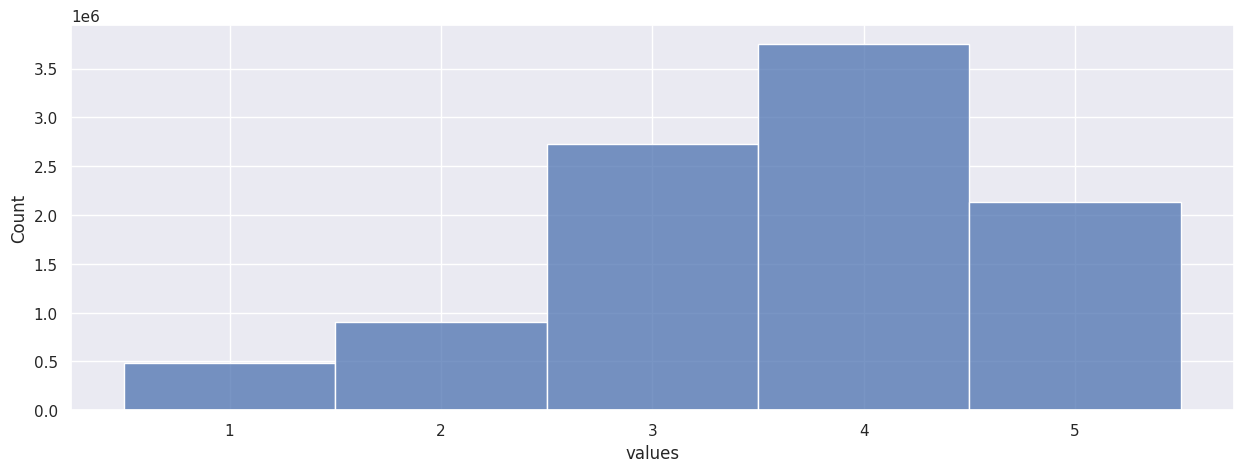

In [ ]:
sns.histplot(data=ratings["values"], binwidth=1)
plt.show()

### 2.2 Построим Rating Distribution

Rating Distribution -- график, который показывает отношение количества рейтингов к количеству юзеров. Он отлично подходит, чтобы визуализировать popularity-skew в данных. По оси y располагаем количество рейтингов, выраженное в процентах от общего количества. По оси x — айтемы сортированные в порядке убывания по количеству рейтингов на них. Ну и также ставим для них в качестве id — процент.

In [6]:
def rating_distribution(column: str) -> None:
    # Compute
    ratings_dist = ratings[column].value_counts(normalize=True).reset_index()
    ratings_dist.columns = [column, "num_ratings_percent"]
    step = 1 / (ratings_dist.shape[0] - 1)
    ratings_dist[f"{column}_percent"] = np.arange(0, 1 + step, step) * 100
    ratings_dist["num_ratings_percent"] = (
        np.cumsum(ratings_dist["num_ratings_percent"]) * 100
    )
    # Plot
    fig, ax = plt.subplots()
    sns.lineplot(
        data=ratings_dist, x=f"{column}_percent", y="num_ratings_percent", ax=ax
    )
    ax.set_xlim(0, 100)
    ax.set_xticks(range(0, 101, 2))
    ax.set_title("Rating Distribution")
    plt.show()

Для `item`:

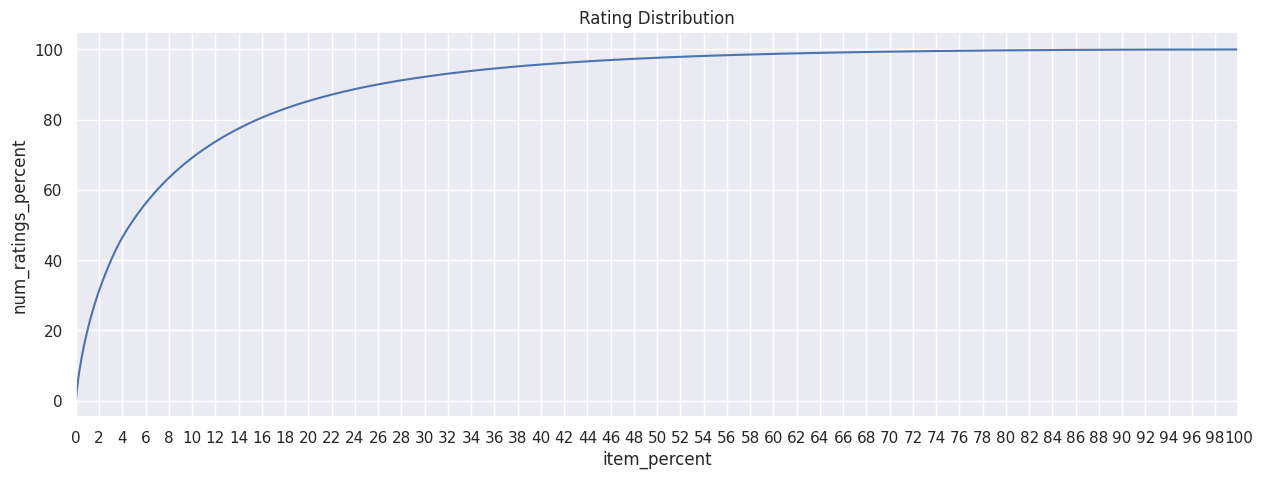

In [ ]:
rating_distribution(column="item")

То есть, например, 80% рейтингов было выставлено всего 16-ти процентам фильмов

Для `user`:

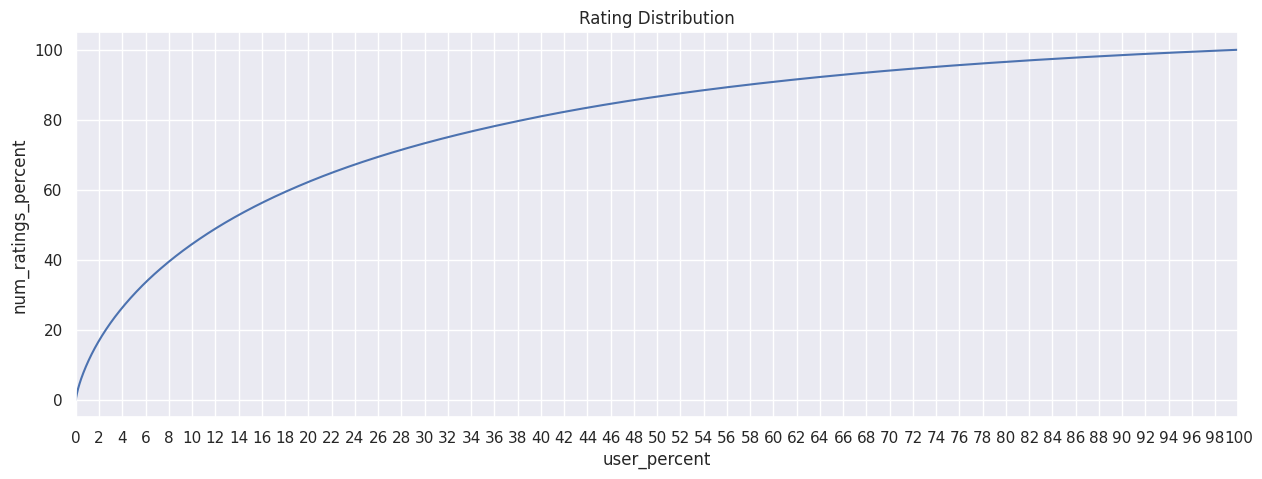

In [ ]:
rating_distribution(column="user")

60% рейтингов высталено 18-ю процентами пользователей (просто объяснения что значит, что точка принадлежит графику)

## 3. Preprocessing

- **valid_items**
    - получим элементы, которые встречаются реже чем threshold. Полезно, чтобы исключить супер популярные айтемы и активных юзеров.
- **filter_ratings**
    - оставим только рейтинги выше `min_rating` (полезно если хотим сделать implicit датасет)
    - оставим users и items, которые встречаются не реже `min_user_count`, `min_item_count` соответственно.

In [7]:
from typing import Union


class CleanData:
  def __init__(self,
               data: pd.DataFrame):
    self.data = data


  def valid_elements(self,
                     column: str,
                     threshold: float = 0.2
                    ) -> Set[int]:
      """
      Method remover top unique values of input column
        column: column which we want to clean from unvalid data
        treshold: which percent of top walues we wanna remove
      """
      rating_dist = self.data[column].value_counts().reset_index()
      cut_off = round(threshold * rating_dist.shape[0]) + 1
      return set(rating_dist.index[cut_off:])


  def get_count(self,
                column: str
              ) -> pd.DataFrame:
      """
        column: which column to gruoup by
      """
      grouped_by_column = self.data.groupby(column, as_index=False)
      return grouped_by_column.size()


  def _filter_ratings(self,
                     data: pd.DataFrame,
                     min_rating: float = 3.0,
                     min_user_count: int = 3,
                     min_item_count: int = 3,
                   ) -> pd.DataFrame:
      """
      Method cut unnecessary (outbreak) data, like low marks and inactive users
        min_rating: all marks with lower rating would not be taken in accout
        min_user_count: min number of users that had marked an element
        min_item_count: min number of elements marked by user
      """
      if min_rating is not None:
          data = data.loc[data["values"] > min_rating]

      if min_item_count > 0:
          itemcount = self.get_count(column="item")
          data = data.loc[
              data["item"].isin(itemcount.item[itemcount["size"] >= min_item_count])
        ]
      if min_user_count > 0:
          usercount = self.get_count(column="user")
          data = data.loc[
              data["user"].isin(usercount.user[usercount["size"] >= min_user_count])
          ]
      return data


  def filter_ratings(self,
                     min_rating: float = 3.0,
                     min_user_count: int = 3,
                     min_item_count: int = 3,
                     remove_top_items: Union[bool, float] = True,
                  ) -> pd.DataFrame:
      """
        min_rating: all marks with lower rating would not be taken in accout
        min_user_count: min number of users that had marked an element
        min_item_count: min number of elements marked by user
        remove_top_items: percent of top items which we wanna to remove
      """
      data = self.data.copy()

      if float(remove_top_items) > 0:
          if type(remove_top_items) == float:
            valid_items = self.valid_elements(column="item", threshold=remove_top_items)
            print('tops')
          else:
            valid_items = self.valid_elements(column="item")
          data = data.loc[data["item"].isin(valid_items)]

      while True:
          cur_num_rows = data.shape[0]
          data = self._filter_ratings(data, min_rating, min_user_count, min_item_count)
          new_num_rows = data.shape[0]
          if cur_num_rows == new_num_rows:
              break
      return data

In [8]:
cleaner = CleanData(ratings)


implicit_filtered_ratings = cleaner.filter_ratings().reset_index(drop=True)
print(f"Before: {ratings.shape}; After: {implicit_filtered_ratings.shape}")

explicit_filtered_ratings = cleaner.filter_ratings(min_rating=None).reset_index(drop=True)
print(f"Before: {ratings.shape}; After: {explicit_filtered_ratings.shape}")

Before: (10000054, 4); After: (2338552, 4)
Before: (10000054, 4); After: (3998461, 4)


### Encoder для данных

Мы, когда чистили датасет удалили часть юзеров и часть айтемов, теперь хотим опять сделать нормальную нумерацию (была же сквозная, а мы из нее часть элементов выбили)

In [9]:
from sklearn.preprocessing import LabelEncoder

for col in ['user', 'item']:
  encoder = LabelEncoder()

  explicit_filtered_ratings[col] = encoder.fit_transform(explicit_filtered_ratings[col])
  implicit_filtered_ratings[col] = encoder.transform(implicit_filtered_ratings[col])

In [ ]:
implicit_filtered_ratings

user  item  values           timestamp
0            0  1260     4.0 2006-11-30 11:19:50
1            0  1529     4.5 2006-01-01 00:38:35
2            0  2373     4.0 2006-11-30 11:18:46
3            0  2515     4.0 2006-01-01 00:38:44
4            0  2829     4.5 2005-12-03 00:53:20
...        ...   ...     ...                 ...
2338547  47536  1652     4.0 2000-11-15 13:37:47
2338548  47536  1655     4.0 2000-11-15 13:33:54
2338549  47536  1656     4.0 2000-11-15 13:26:26
2338550  47536  2894     4.0 2000-11-15 13:24:52
2338551  47537   158     5.0 1998-12-02 05:52:48

[2338552 rows x 4 columns]

### 3.3 Split

Тестовая выборка - out of time, иначе говоря, берем последний год из базы как тестовую выборку, а на остальном будем обучаться. Обычно такая же ситуация и в реальности: у нас есть какая-то история, а мы хотим предсказать что в будущем пользователь захочет посмотреть и порекомендовать ему это

Также для нашей задачи выкинем одного и двух пользователей из исходного датасета. То есть у нас будет три датасета: со всеми пользователями, без одного и без двух. Это нужно для проверки скорости работы прямого пересчета SVD при добавление одного-двух пользователей и скорости работы алгоритма, который пересчитывает SVD по-умному, основываясь на разложении, которое было для $(n-1)$-ого пользователя. Выкидывать будем последних пользователей, что encoding не поехал

In [10]:
def remove_users(dataset: pd.DataFrame,
                 n: int = 2
                ) -> pd.DataFrame:
  """
  Method to remove users from dataset to test adding them to existing svd
    dataset: out dataset from which we wanna remove users
    n: number of users we wanna remove
  """
  to_remove = dataset['user'].sort_values().unique()[-n:]
  main_dataset = dataset[~dataset['user'].isin(to_remove)]
  removed_users = dataset[dataset['user'].isin(to_remove)]

  return [main_dataset, removed_users]


In [11]:
explicit_filtered_remove2, explicit_removed2_dataset = remove_users(explicit_filtered_ratings)
implicit_filtered_remove2, implicit_removed2_dataset = remove_users(implicit_filtered_ratings)

In [ ]:
explicit_filtered_remove2

user  item  values           timestamp
0            0  1260     4.0 2006-11-30 11:19:50
1            0  1529     4.5 2006-01-01 00:38:35
2            0  2373     4.0 2006-11-30 11:18:46
3            0  2515     4.0 2006-01-01 00:38:44
4            0  2829     4.5 2005-12-03 00:53:20
...        ...   ...     ...                 ...
3998392  47535  5112     3.5 2005-03-23 02:37:08
3998393  47535  5741     2.5 2005-03-23 02:36:05
3998394  47535  5780     3.0 2005-03-23 02:40:01
3998395  47535  5806     4.5 2005-03-23 02:33:02
3998396  47535  5819     3.0 2005-03-23 02:46:51

[3998397 rows x 4 columns]

In [ ]:
explicit_removed2_dataset

user  item  values           timestamp
3998397  47536    11     3.0 2000-11-15 13:20:35
3998398  47536    31     1.0 2000-11-16 13:53:37
3998399  47536   200     4.0 2000-11-15 13:20:50
3998400  47536   210     3.0 2000-11-15 13:28:54
3998401  47536   233     4.0 2000-11-15 13:20:35
...        ...   ...     ...                 ...
3998456  47536  1656     4.0 2000-11-15 13:26:26
3998457  47536  2894     4.0 2000-11-15 13:24:52
3998458  47537   158     5.0 1998-12-02 05:52:48
3998459  47537   202     2.0 1998-12-02 05:53:36
3998460  47537   248     2.0 1998-12-02 05:56:13

[64 rows x 4 columns]

In [ ]:
explicit_filtered_ratings

user  item  values           timestamp
0            0  1260     4.0 2006-11-30 11:19:50
1            0  1529     4.5 2006-01-01 00:38:35
2            0  2373     4.0 2006-11-30 11:18:46
3            0  2515     4.0 2006-01-01 00:38:44
4            0  2829     4.5 2005-12-03 00:53:20
...        ...   ...     ...                 ...
3998456  47536  1656     4.0 2000-11-15 13:26:26
3998457  47536  2894     4.0 2000-11-15 13:24:52
3998458  47537   158     5.0 1998-12-02 05:52:48
3998459  47537   202     2.0 1998-12-02 05:53:36
3998460  47537   248     2.0 1998-12-02 05:56:13

[3998461 rows x 4 columns]

In [12]:
explicit_filtered_remove1, explicit_removed1_dataset = remove_users(explicit_filtered_ratings, n=1)
implicit_filtered_remove1, implicit_removed1_dataset = remove_users(implicit_filtered_ratings, n=1)

In [13]:
ts_split = {
    "implicit": implicit_filtered_ratings["timestamp"].max()
    - pd.Timedelta(365, "days"),
    "explicit": explicit_filtered_ratings["timestamp"].max()
    - pd.Timedelta(365, "days"),
}
datasets_full = {}
for key, dataset in (
    ("implicit", implicit_filtered_ratings),
    ("explicit", explicit_filtered_ratings),
):
    datasets_full[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_full[key]["valid"] = datasets_full[key]["valid"].loc[
        datasets_full[key]["valid"].user.isin(datasets_full[key]["train"].user.unique())
    ]

In [14]:
ts_split = {
    "implicit": implicit_filtered_remove1["timestamp"].max()
    - pd.Timedelta(365, "days"),
    "explicit": explicit_filtered_remove1["timestamp"].max()
    - pd.Timedelta(365, "days"),
}
datasets_minus1 = {}
for key, dataset in (
    ("implicit", implicit_filtered_remove1),
    ("explicit", explicit_filtered_remove1),
):
    datasets_minus1[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_minus1[key]["valid"] = datasets_minus1[key]["valid"].loc[
        datasets_minus1[key]["valid"].user.isin(datasets_minus1[key]["train"].user.unique())
    ]

In [15]:
ts_split = {
    "implicit": implicit_filtered_remove2["timestamp"].max()
    - pd.Timedelta(365, "days"),
    "explicit": explicit_filtered_remove2["timestamp"].max()
    - pd.Timedelta(365, "days"),
}
datasets_minus2 = {}
for key, dataset in (
    ("implicit", implicit_filtered_remove2),
    ("explicit", explicit_filtered_remove2),
):
    datasets_minus2[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_minus2[key]["valid"] = datasets_minus2[key]["valid"].loc[
        datasets_minus2[key]["valid"].user.isin(datasets_minus2[key]["train"].user.unique())
    ]

In [ ]:
datasets_minus1

{'implicit': {'train':           user  item  values           timestamp
  0            0  1260     4.0 2006-11-30 11:19:50
  1            0  1529     4.5 2006-01-01 00:38:35
  2            0  2373     4.0 2006-11-30 11:18:46
  3            0  2515     4.0 2006-01-01 00:38:44
  4            0  2829     4.5 2005-12-03 00:53:20
  ...        ...   ...     ...                 ...
  2338546  47536  1633     4.0 2000-11-15 13:41:22
  2338547  47536  1652     4.0 2000-11-15 13:37:47
  2338548  47536  1655     4.0 2000-11-15 13:33:54
  2338549  47536  1656     4.0 2000-11-15 13:26:26
  2338550  47536  2894     4.0 2000-11-15 13:24:52
  
  [2128722 rows x 4 columns],
  'valid':           user  item  values           timestamp
  889         20  1412     4.5 2008-04-20 05:35:35
  925         20  3178     4.0 2008-04-20 05:33:46
  1714        42  1286     4.0 2008-06-19 23:47:17
  1715        42  1528     5.0 2008-06-19 23:57:50
  1718        42  2807     5.0 2008-06-19 23:48:56
  ...        ...   

In [16]:
def make_sparse(dataset: pd.DataFrame,
                binary: bool = False,
              ) -> sps.csr_matrix:
    """
    Method for creating matrix, that will have item and user unique labels as axises and will be filled by scores (that user gived to item)
      dataset: our dataset
      binary: flag if we want to put just 1 instead of scores
    """
    shape = (explicit_filtered_ratings['user'].nunique(), explicit_filtered_ratings['item'].nunique())
    values = dataset["values"].to_numpy()
    values = np.ones_like(values) if binary else values
    row = np.array(dataset["user"].to_numpy())
    column = np.array(dataset["item"].to_numpy())
    return sps.csr_matrix(
                          (values, (row, column)),
                          shape=shape
                          )


def build_sparse_datasets(train: pd.DataFrame,
                          valid: pd.DataFrame,
                          binary: bool = True,
                        ) -> dict[str, dict[str, sps.csr_matrix]]:
    """
    Wrapper for make_sparse method
    """
    train_sparse = make_sparse(train, binary=binary)
    valid_sparse = make_sparse(valid, binary=binary)
    train_mask, valid_mask = (
        train_sparse.getnnz(axis=-1) > 0,
        valid_sparse.getnnz(axis=-1) > 0,
    )
    return {
        "train": {
            "source": train_sparse[train_mask],
            "target": train_sparse[train_mask],
        },
        "valid": {
            "source": valid_sparse[valid_mask],
            "target": valid_sparse[valid_mask],
        },
    }

In [17]:
explicit_full_datasets = build_sparse_datasets(
    **datasets_full["explicit"], binary=False
)
implicit_full_datasets = build_sparse_datasets(
    **datasets_full["implicit"], binary=True
)
print("Explicit")
pprint(explicit_full_datasets)
print("Implicit")
pprint(implicit_full_datasets)

Explicit
{'train': {'source': <43239x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679915 stored elements in Compressed Sparse Row format>,
           'target': <43239x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679915 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>,
           'target': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>}}
Implicit
{'train': {'source': <42583x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128723 stored elements in Compressed Sparse Row format>,
           'target': <42583x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128723 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2261x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 34365 stored elements in Comp

In [18]:
explicit_minus1_datasets = build_sparse_datasets(
    **datasets_minus1["explicit"], binary=False
)
implicit_minus1_datasets = build_sparse_datasets(
    **datasets_minus1["implicit"], binary=True
)
print("Explicit")
pprint(explicit_minus1_datasets)
print("Implicit")
pprint(implicit_minus1_datasets)

Explicit
{'train': {'source': <43238x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679912 stored elements in Compressed Sparse Row format>,
           'target': <43238x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679912 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>,
           'target': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>}}
Implicit
{'train': {'source': <42582x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128722 stored elements in Compressed Sparse Row format>,
           'target': <42582x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128722 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2261x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 34365 stored elements in Comp

In [19]:
explicit_minus2_datasets = build_sparse_datasets(
    **datasets_minus2["explicit"], binary=False
)
implicit_minus2_datasets = build_sparse_datasets(
    **datasets_minus2["implicit"], binary=True
)
print("Explicit")
pprint(explicit_minus2_datasets)
print("Implicit")
pprint(implicit_minus2_datasets)

Explicit
{'train': {'source': <43237x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679851 stored elements in Compressed Sparse Row format>,
           'target': <43237x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679851 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>,
           'target': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>}}
Implicit
{'train': {'source': <42581x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128685 stored elements in Compressed Sparse Row format>,
           'target': <42581x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128685 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2261x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 34365 stored elements in Comp

### 3.4 Готовим лоадеры для данных

Сложим все аккуратно по батчам для удобства дальнейшего обучения

In [20]:
class MovieLensDataset(Dataset):
    def __init__(self, source: sps.csc_matrix, target: sps.csr_matrix = None) -> None:
        self._source = source
        self._target = target

    def __len__(self):
        return self._source.shape[0]

    def __getitem__(self, idx: int) -> dict[str, np.ndarray]:
        item = {"source": self._source[idx]}
        if self._target is not None:
            item["target"] = self._target[idx]
        return item

In [21]:
class MovieLensCollator:
    def __call__(
        self, instances: Iterable[dict[str, sps.csr_matrix]]
    ) -> dict[str, torch.Tensor]:
        batch = self._make_batch(instances)
        for key, tensor in batch.items():
            batch[key] = (
                self._to_sparse(tensor).to_dense().float()
                if isinstance(tensor[0], sps.csr_matrix)
                else torch.Tensor(tensor)
            )
        return dict(batch)

    @staticmethod
    def _make_batch(
        instances: Iterable[dict[str, sps.csr_matrix]]
    ) -> dict[str, list[sps.csr_matrix]]:
        tensor_dict = defaultdict(list)
        for instance in instances:
            for field, tensor in instance.items():
                tensor_dict[field].append(tensor)
        return tensor_dict

    @staticmethod
    def _to_sparse(tensor: list[sps.csr_matrix]) -> torch.sparse.Tensor:
        tensor = sps.vstack(tensor)
        values = torch.from_numpy(tensor.data)
        indices = torch.from_numpy(np.vstack(tensor.nonzero())).long()
        sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
        return sparse_tensor

## 4. Наши методы

###  Sparse Model и Runner

#### Sparse Model

Сделаем базовый класс, он зафиксирует тот факт, что модель состоит из 2 функций:
- Обучение — `.fit()`. Каждая модель обучается только на `train.source` части из датасетов.
- Инфер — `.predict_proba()`. Делаем инфер на батче данных из `(train|valid).source` и сравниваем с ответами в `(train|valid).target`, если добавили callback с метриками. Ответ каждой модели — словарь. Мы решили остановиться на dict только с одним ключом **logits**.

И еще тот факт, что у нас данные на cpu храниться будут

И да ещё один важный момент. У каждой модели есть параметр `remove_seen`. С помощью него из предсказний модели, можно убрать айтемы, которые юзер видел во время обучения. В итоге мы всегда будем рекомендовать только что-то новое для клиентов.

#### Runner

Runner решает только одну задачу — прогон модели на данных. `fit` делаем на всех данных, а `predict_proba` батчевым образом, чтобы сэкономить на памяти.

In [22]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
class SparseModel(ABC):
    def __init__(self, remove_seen: bool = True) -> None:
        self.remove_seen = remove_seen
        self.device = torch.device("cpu")

    @abstractmethod
    def fit(self, data: sps.csr_matrix) -> None:
        pass

    @abstractmethod
    def predict_proba(self, batch: dict[str, Any]) -> dict[str, torch.Tensor]:
        pass

    def to(self, device: torch.device) -> "SparseModel":
        self.device = device
        return self

In [24]:
class SparseRunner(IExperiment):
    def __init__(
                self,
                model: SparseModel,
                seed: int = 13,
                batch_size: int = 32,
                device: torch.device = torch.device("cpu"),
                callbacks: dict[str, ICallback] = None,
                target_threshold: float = 0.0,
              ) -> None:
        super().__init__()
        self.seed = seed
        self.model = model.to(device)
        self.device = device
        self.callbacks = callbacks or defaultdict(None)
        self._batch_size = batch_size
        self._target_threshold = target_threshold
        # Extra variables
        self.batch_output: dict[str, torch.Tensor] = None
        self.batch_target: torch.Tensor = None

    def run_dataset(self) -> None:
        if self.is_train_dataset:
            self.model.fit(self.dataset["source"])
        self.dataset = tqdm(
            DataLoader(
                MovieLensDataset(**self.dataset),
                collate_fn=MovieLensCollator(),
                batch_size=self._batch_size,
                shuffle=True,
                num_workers=1,
                pin_memory=True,
            ),
            desc=f"Iterating {self.dataset_key}",
        )
        # Remove seen items only for validation
        self.model.remove_seen = not self.is_train_dataset
        super().run_dataset()

    def run_batch(self) -> None:
        self.batch = {k: v.to(self.device) for k, v in self.batch.items()}
        self.batch_target = self.batch["target"].gt(self._target_threshold).float()
        self.batch_output = self.model.predict_proba(self.batch)

    def run(self, datasets: dict[str, dict[str, sps.csr_matrix]]) -> None:
        self.datasets = datasets
        super().run()

In [ ]:
dataset_example_train = MovieLensDataset(**implicit_full_datasets["train"])

In [ ]:
loader_example = DataLoader(
    dataset_example_train,
    collate_fn=MovieLensCollator(),
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

### 4.1 Baseline

Модель TopPopular. Получаем список самых популярных айтемов по суммированию рейтингов и рекомендуем всем эти вот самые популярные айтемы (тут не будет никакой разницы между explicit и implicit)

In [25]:
class TopPopularModel(SparseModel):
    def __init__(self,
                 remove_seen: bool = True
                ) -> None:
        super().__init__(remove_seen=remove_seen)
        self._stats = {}

    def fit(self,
            data: sps.csr_matrix
          ) -> None:
        self._logits = (
          torch.from_numpy(np.array(data.sum(axis=0), dtype=np.float32))
          .view(-1)
          .to(self.device)
        )
        self._stats["item_freq"] = self._logits

    def predict_proba(self,
                      batch: dict[str, Any]
                    ) -> dict[str, torch.Tensor]:
        scores = self._logits.repeat(batch["source"].size(0), 1)
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [ ]:
top_popular_full = SparseRunner(model=TopPopularModel(), device=device)

print("Implicit")
top_popular_full.run(implicit_full_datasets)
print("Explicit")
top_popular_full.run(explicit_full_datasets)

Implicit


Iterating train:   0%|          | 0/1331 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 71/71 [00:01<00:00, 66.92it/s]


Explicit


Iterating train:   0%|          | 0/1352 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/75 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 75/75 [00:01<00:00, 49.33it/s]


In [ ]:
top_popular_minus1 = SparseRunner(model=TopPopularModel(), device=device)

print("Implicit")
top_popular_minus1.run(implicit_minus1_datasets)
print("Explicit")
top_popular_minus1.run(explicit_minus1_datasets)

Implicit


Iterating train:   0%|          | 0/1331 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 71/71 [00:01<00:00, 61.85it/s]


Explicit


Iterating train:   0%|          | 0/1352 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/75 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 75/75 [00:01<00:00, 63.76it/s]


In [ ]:
top_popular_minus2 = SparseRunner(model=TopPopularModel(), device=device)

print("Implicit")
top_popular_minus2.run(implicit_minus2_datasets)
print("Explicit")
top_popular_minus2.run(explicit_minus2_datasets)

Implicit


Iterating train:   0%|          | 0/1331 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 71/71 [00:00<00:00, 73.39it/s]


Explicit


Iterating train:   0%|          | 0/1352 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/75 [00:00<?, ?it/s]<ipython-input-31-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 75/75 [00:01<00:00, 68.29it/s]


### 4.2 Built-in SVD

В `predict_proba` мы воспользуемся ортогональностью матриц $U \sim R^{\text{(num users) x (factors)}}$ и $V \sim R^{\text{(num items) x (factors)}}$. Благодаря этому инфер можно записать вот так: $\hat{r}_u = r_u \cdot V \cdot V^T$

Пользуемся встроенным методом разложения SVD, т.к. по скорости он значительно лучше, чем прописанный вручную. Если будет время, можно будет и вручную прописать. Тут полезно замерить время работы

На такой большой матрице SVD считается жутко долго, даже если передавать в scipy sparse матрицу, поэтому на всем датасете будем считать неполное SVD (128 главных компонент). Потом возьмем в трейн матрицу поменьше, чтобы посчитать полное SVD

In [26]:
import time

In [27]:
class Built_in_SvdModel(SparseModel):
    """
    factors: ~number of singular values that we compute
    remove_seen: flag if we want to remove items that user saw while training (make only new recommendations)
    """
    def __init__(self,
                 factors: int,
                 remove_seen: bool = True
                ) -> None:
        super().__init__(remove_seen=remove_seen)
        self._factors = factors
        self.factors = {}
        self.svd = None


    def fit(self,
            data: sps.csr_matrix
          ) -> None:

        start_time = time.time()
        u, sigma, vt = sps.linalg.svds(data, k=self._factors)
        end_time = time.time()
        self.computation_time = end_time - start_time
        print("--- %s seconds svd computation---" % (end_time - start_time))

        self.svd = [u, sigma, vt]

        self.factors = {
            "user": torch.from_numpy(u.copy()).float().to(self.device),
            "item": torch.einsum(
                "fi->if", torch.from_numpy(vt).float().to(self.device)
            ),
        }


    def predict_proba(self,
                      batch: dict[str, Any]
                    ) -> dict[str, torch.Tensor]:
        scores = torch.einsum(
            "ui,if,jf->uj", batch["source"], self.factors["item"], self.factors["item"]
        )
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [ ]:
built_in_svd_runner_full = SparseRunner(model=Built_in_SvdModel(factors = 128), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_full.run(implicit_full_datasets)
print("Explicit")
built_in_svd_runner_full.run(explicit_full_datasets)

Implicit
--- 7.01561427116394 seconds svd computation---


Iterating train:   0%|          | 0/84 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Explicit
--- 11.876492261886597 seconds svd computation---


Iterating train:   0%|          | 0/85 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


In [ ]:
built_in_svd_runner_minus1 = SparseRunner(model=Built_in_SvdModel(factors = 128), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_minus1.run(implicit_minus1_datasets)
print("Explicit")
built_in_svd_runner_minus1.run(explicit_minus1_datasets)

Implicit
--- 7.0442352294921875 seconds svd computation---


Iterating train:   0%|          | 0/84 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


Explicit
--- 9.588705062866211 seconds svd computation---


Iterating train:   0%|          | 0/85 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


In [ ]:
built_in_svd_runner_minus2 = SparseRunner(model=Built_in_SvdModel(factors = 128), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_minus2.run(implicit_minus2_datasets)
print("Explicit")
built_in_svd_runner_minus2.run(explicit_minus2_datasets)

Implicit
--- 6.718226671218872 seconds svd computation---


Iterating train:   0%|          | 0/84 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  6.05it/s]


Explicit
--- 8.577771663665771 seconds svd computation---


Iterating train:   0%|          | 0/85 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-24-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


In [ ]:
built_in_svd_runner_minus2.model.svd[0].shape

(43237, 127)

Берем датасет поменьше - оставим 5000 пользователей (чтобы полное SVD посчитать)

In [28]:
explicit_small, explicit_small_removed = remove_users(explicit_filtered_ratings, n = 42537)
implicit_small, implicit_small_removed = remove_users(implicit_filtered_ratings, n = 42537)

In [ ]:
explicit_small

user  item  values           timestamp
0          0  1260     4.0 2006-11-30 11:19:50
1          0  1529     4.5 2006-01-01 00:38:35
2          0  2373     4.0 2006-11-30 11:18:46
3          0  2515     4.0 2006-01-01 00:38:44
4          0  2829     4.5 2005-12-03 00:53:20
...      ...   ...     ...                 ...
394692  5000  3614     4.5 2006-12-01 10:23:08
394693  5000  4172     0.5 2006-12-01 11:02:05
394694  5000  4724     0.5 2006-12-01 11:02:04
394695  5000  4940     4.0 2006-12-01 11:01:03
394696  5000  5540     3.0 2006-12-01 10:25:12

[394697 rows x 4 columns]

С этим датасетом надо проделать то же, что мы делали выше. Только SVD полное посчитать через np.linalg.svd

In [29]:
explicit_small_remove2, explicit_small_removed2 = remove_users(explicit_small)
implicit_small_remove2, implicit_small_removed2 = remove_users(implicit_small)

explicit_small_remove1, explicit_small_removed1= remove_users(explicit_small, n=1)
implicit_small_remove1, implicit_small_removed1 = remove_users(implicit_small, n=1)

In [30]:
ts_split = {
    "implicit": implicit_small["timestamp"].max()
    - pd.Timedelta(165, "days"),
    "explicit": explicit_small["timestamp"].max()
    - pd.Timedelta(165, "days"),
}
datasets_small = {}
for key, dataset in (
    ("implicit", implicit_small),
    ("explicit", explicit_small),
):
    datasets_small[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_small[key]["valid"] = datasets_small[key]["valid"].loc[
        datasets_small[key]["valid"].user.isin(datasets_small[key]["train"].user.unique())
    ]

ts_split = {
    "implicit": implicit_small_remove2["timestamp"].max()
    - pd.Timedelta(165, "days"),
    "explicit": explicit_small_remove2["timestamp"].max()
    - pd.Timedelta(165, "days"),
}
datasets_small_minus2 = {}
for key, dataset in (
    ("implicit", implicit_small_remove2),
    ("explicit", explicit_small_remove2),
):
    datasets_small_minus2[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_small_minus2[key]["valid"] = datasets_small_minus2[key]["valid"].loc[
        datasets_small_minus2[key]["valid"].user.isin(datasets_small_minus2[key]["train"].user.unique())
    ]

ts_split = {
    "implicit": implicit_small_remove1["timestamp"].max()
    - pd.Timedelta(165, "days"),
    "explicit": explicit_small_remove1["timestamp"].max()
    - pd.Timedelta(165, "days"),
}
datasets_small_minus1 = {}
for key, dataset in (
    ("implicit", implicit_small_remove1),
    ("explicit", explicit_small_remove1),
):
    datasets_small_minus1[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_small_minus1[key]["valid"] = datasets_small_minus1[key]["valid"].loc[
        datasets_small_minus1[key]["valid"].user.isin(datasets_small_minus1[key]["train"].user.unique())
    ]

In [40]:
explicit_small_datasets = build_sparse_datasets(
    **datasets_small["explicit"], binary=False
)
implicit_small_datasets = build_sparse_datasets(
    **datasets_small["implicit"], binary=True
)

explicit_small_datasets_minus2 = build_sparse_datasets(
    **datasets_small_minus2["explicit"], binary=False
)
implicit_small_datasets_minus2 = build_sparse_datasets(
    **datasets_small_minus2["implicit"], binary=True
)

explicit_small_datasets_minus1 = build_sparse_datasets(
    **datasets_small_minus1["explicit"], binary=False
)
implicit_small_datasets_minus1 = build_sparse_datasets(
    **datasets_small_minus1["implicit"], binary=True
)

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
class Built_in_SvdModel(SparseModel):
    """
    remove_seen: flag if we want to remove items that user saw while training (make only new recommendations)
    """
    def __init__(self,
                 remove_seen: bool = True
                ) -> None:
        super().__init__(remove_seen=remove_seen)
        self.factors = {}
        self.svd = None


    def fit(self,
            data: sps.csr_matrix
          ) -> None:

        start_time = time.time()
        u, sigma, vt = np.linalg.svd(data.todense())
        end_time = time.time()
        self.computation_time = end_time - start_time
        print("--- %s seconds svd computation---" % (end_time - start_time))

        self.svd = [u, sigma, vt]

        self.factors = {
            "user": torch.from_numpy(u.copy()).float().to(self.device),
            "item": torch.einsum(
                "fi->if", torch.from_numpy(vt).float().to(self.device)
            ),
        }


    def predict_proba(self,
                      batch: dict[str, Any]
                    ) -> dict[str, torch.Tensor]:
        scores = torch.einsum(
            "ui,if,jf->uj", batch["source"], self.factors["item"], self.factors["item"]
        )
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [39]:
built_in_svd_runner_small_impicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
built_in_svd_runner_small_explicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_small_impicit.run(implicit_small_datasets)
print("Explicit")
built_in_svd_runner_small_explicit.run(explicit_small_datasets)

Implicit
--- 129.62959623336792 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Explicit
--- 120.89707922935486 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


In [41]:
built_in_svd_runner_small_minus2_impicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
built_in_svd_runner_small_minus2_explicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_small_minus2_impicit.run(implicit_small_datasets_minus2)
print("Explicit")
built_in_svd_runner_small_minus2_explicit.run(explicit_small_datasets_minus2)

Implicit
--- 94.07006359100342 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


Explicit
--- 116.63519835472107 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


In [42]:
built_in_svd_runner_small_minus1_impicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
built_in_svd_runner_small_minus1_explicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_small_minus1_impicit.run(implicit_small_datasets_minus1)
print("Explicit")
built_in_svd_runner_small_minus1_explicit.run(explicit_small_datasets_minus1)

Implicit
--- 94.11385869979858 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Explicit
--- 124.18339204788208 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


### 4.3 Rank-one SVD Model

runner.model - тут будет лежать обученная базовая модель, где уже посчитался svd (runner.model.svd). Нужно вот весь runner.model взять, подать в свой класс, а затем уже реализовывать добавление пользователя



In [44]:
class Rank_one_SvdModel(SparseModel):
    """
    remove_seen: flag if we want to remove items that user saw while training (make only new recommendations)
    """
    def __init__(self,
                 trained_model,
                 trained_model_on_minus1,
                ) -> None:
        super().__init__(remove_seen=trained_model.remove_seen)
        self.trained_model = trained_model
        self.trained_model_on_minus1 = trained_model_on_minus1
        self.true_svd = trained_model.svd
        self.svd_on_minus1_users = trained_model_on_minus1.svd


    def fit(self,
            data: sps.csr_matrix
          ) -> None:
        """
          data - обычная матрица, нужно подать в fit одного кандидата (new_user) и, собственно, прописать алгоритм метода.
          Дальше, главное, вывести явно матрицы u vt и не удалять строку с self.factors, потому что эти матрицы туда грузятся,
          и затем используются для предикта
        """

        # тут должен быть тот самый rank one алгоритм подсчета svd не прямым методом, для этого есть self.svd_on_minus1_users -
        # svd разложение для матрицы без одного пользователя. Также есть self.true_svd для оценки неточности восстановления

        self.factors = {
            "user": torch.from_numpy(u.copy()).float().to(self.device),
            "item": torch.einsum(
                "fi->if", torch.from_numpy(vt).float().to(self.device)
            ),
        }


    def predict_proba(self,
                      batch: dict[str, Any]
                    ) -> dict[str, torch.Tensor]:
        scores = torch.einsum(
            "ui,if,jf->uj", batch["source"], self.factors["item"], self.factors["item"]
        )
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [45]:
rank1_svd_runner_small_impicit = SparseRunner(model=Rank_one_SvdModel(built_in_svd_runner_small_impicit.model,
                                                                      built_in_svd_runner_small_minus1_impicit.model), batch_size=512, device=device)
rank1_svd_runner_small_explicit = SparseRunner(model=Rank_one_SvdModel(built_in_svd_runner_small_explicit.model,
                                                                      built_in_svd_runner_small_minus1_explicit.model), batch_size=512, device=device)

In [46]:
rank1_svd_runner_small_impicit.model.true_svd[1].shape

(4272,)

In [47]:
rank1_svd_runner_small_impicit.model.svd_on_minus1_users[1].shape

(4271,)

## 5. Evaluation

$target_{sort}$ — таргет, сортированный в соответствии с логитами модели по убыванию.

Так как мы всё делаем через animus, сделаем второй callback, чтобы красиво визуализировать метрики моделей.

In [ ]:
class MetricCallback(ICallback):
    def __init__(self, func: Callable, topk: list[int], input_key: str) -> None:
        self._name = func.__name__
        self._func = func
        self._topk = topk
        self._input_key = input_key
        self._total_sum = {k: 0 for k in self._topk}
        self._num_batches = 0

    def _get_metric(self) -> dict[str, float]:
        return {
            f"{self._name}@{k}": metric_sum / self._num_batches
            for k, metric_sum in self._total_sum.items()
        }

    def on_dataset_start(self, exp: IExperiment) -> None:
        self._total_sum = {k: 0 for k in self._topk}
        self._num_batches = 0

    def on_batch_end(self, exp: IExperiment) -> None:
        for k in self._topk:
            self._total_sum[k] += self._func(
                exp.batch_output[self._input_key], exp.batch_target, topk=k
            ).item()
        self._num_batches += 1
        exp.batch_metrics.update(self._get_metric())

    def on_dataset_end(self, exp: IExperiment) -> None:
        exp.dataset_metrics.update(self._get_metric())

In [ ]:
class LoggerCallback(ICallback):
    def on_dataset_end(self, exp: IExperiment) -> None:
        """Run callbacks on dataset end."""
        print(f"{exp.dataset_key.capitalize()} metrics:")
        max_length = max(len(x) for x in exp.dataset_metrics)
        # Sort by length to make it prettier
        for metric in sorted(exp.dataset_metrics, key=self._sort_func):
            metric_value = exp.dataset_metrics.get(metric)
            if isinstance(metric_value, (float, int)):
                print(f"{metric.ljust(max_length)} | {metric_value:.4f}")

    @staticmethod
    def _sort_func(x: str) -> Tuple[int, str, int]:
        if "@" in x:
            metric_key, topk = x.split("@")
            return (len(metric_key), metric_key, int(topk))
        return (len(x), x, 0)

In [ ]:
class PrepareTargetResult(NamedTuple):
    values: torch.Tensor
    indices: torch.Tensor


def validate_metric_inputs(output: torch.Tensor, target: torch.Tensor) -> None:
    if output.size() != target.size():
        raise IndexError(
            "Unequal sizes for output and target: "
            f"output - {output.size()}, target - {target.size()}."
        )
    if not (target.eq(0) | target.eq(1)).all():
        raise ValueError(
            "Target contains values outside of 0 and 1." f"\nTarget:\n{target}"
        )


def prepare_target(
    output: torch.Tensor, target: torch.Tensor, return_indices: bool = False
) -> Union[torch.Tensor, PrepareTargetResult]:
    validate_metric_inputs(output, target)
    # Define order by sorted output scores.
    indices = output.argsort(dim=-1, descending=True)
    sorted_target = torch.gather(target, index=indices, dim=-1)
    return (
        PrepareTargetResult(sorted_target, indices) if return_indices else sorted_target
    )


def nan_to_num(tensor: torch.Tensor, nan: float = 0.0) -> torch.Tensor:
    return torch.where(
        torch.isnan(tensor) | torch.isinf(tensor),
        torch.full_like(tensor, fill_value=nan),
        tensor,
    )

In [ ]:
output, target = (
    torch.randn(size=(10, 13)),
    torch.randint(low=0, high=2, size=(10, 13)).float(),
)

### 5.1 Precision

$$
p@k = \frac{\sum_{i=1}^{k}target_{sort}[i]}{k}
$$

In [ ]:
def precision(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
    topk = min(output.size(-1), topk)
    # target_sorted_by_output ~ (users, topk)
    target_sorted_by_output = prepare_target(output, target)[:, :topk]
    # precision_score ~ (users)
    precision_score = target_sorted_by_output.sum(dim=-1) / topk
    return precision_score.mean()

In [ ]:
precision(output, target, topk=3)

tensor(0.4667)

### 5.2 Recall

$$
r@k = \frac{\sum_{i=1}^{k}target_{sort}[i]}{\sum target}
$$

In [ ]:
def recall(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
    topk = min(output.shape[-1], topk)
    # target_sorted_by_output ~ (users, topk)
    target_sorted_by_output = prepare_target(output, target)[:, :topk]
    # recall_score ~ (users)
    recall_score = nan_to_num(target_sorted_by_output.sum(dim=-1) / target.sum(dim=-1))
    return recall_score.mean()

In [ ]:
recall(output, target, topk=3)

tensor(0.2017)

### 5.3 Mean (Normalized) Average Precision

$ap@k = \frac{1}{\sum_{i=1}^k{target_{sort}[i]}} \sum_{i=1}^k target_{sort}[i] \cdot p@i$
```python
map@k = reduce(ap@k, "users->", reduction="mean")
```

In [ ]:
def mnap(
    output: torch.Tensor, target: torch.Tensor, topk: int, normalized: bool = True
) -> torch.Tensor:
    topk = min(output.size(-1), topk)
    # target_sorted_by_output ~ (users, topk)
    target_sorted_by_output = prepare_target(output, target)[:, :topk]
    # target_cumsum ~ (users, topk)
    target_cumsum = target_sorted_by_output.cumsum(dim=-1)
    # topk_tensor ~ (topk)
    topk_tensor = torch.arange(0, topk, dtype=torch.long, device=output.device)
    # precisions ~ (users, topk)
    precisions = target_cumsum / (topk_tensor + 1.0)
    # relevant_precisions ~ (users, topk)
    relevant_precisions = precisions * target_sorted_by_output
    # Add  normalization if needed
    denominator = (
        target.sum(dim=-1).clamp(max=topk)
        if normalized
        else target_sorted_by_output.sum(dim=-1)
    )
    # ap_score ~ (users)
    ap_score = nan_to_num(relevant_precisions.sum(dim=-1) / denominator)
    return ap_score.mean()

In [ ]:
mnap(output, target, topk=3)

tensor(0.3556)

### 5.4 Normalized Discounted Cumulative Gain

- Cumulative Gain (CG): $CG@k = \sum_{i=1}^k target_{sort}[i]$
- Discounted Cumulative Gain (DCG): $DCG@k = \sum_{i=1}^k \frac{2^{target_{sort}[i]} - 1}{\log(i + 1)}$
- Normalized Discounted Cumulative Gain (nDCG): $nDCG@k = \frac{DCG@k}{idealDCG@k}$

In [ ]:
def dcg(tensor: torch.Tensor) -> torch.Tensor:
    gains = (2**tensor) - 1
    return gains / torch.log2(
        torch.arange(0, tensor.size(-1), dtype=torch.float, device=tensor.device) + 2.0
    )


def ndcg(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
    topk = min(output.size(-1), topk)
    # target_sorted_by_output ~ (users, items)
    target_sorted_by_output = prepare_target(output, target)
    ideal_target = prepare_target(target, target)
    # ideal_dcg ~ (users, topk)
    ideal_dcg = dcg(ideal_target)[:, :topk]
    # prediction_dcg ~ (users, topk)
    prediction_dcg = dcg(target_sorted_by_output)[:, :topk]
    # ideal_dcg_cumsum ~ (users)
    ideal_dcg_score = ideal_dcg.sum(dim=-1)
    # prediction_dcg_cumsum ~ (users)
    prediction_dcg_score = prediction_dcg.sum(dim=-1)
    # ndcg_score ~ (users, items)
    ndcg_score = nan_to_num(prediction_dcg_score / ideal_dcg_score)
    # ndcg_score[ideal_dcg_score.eq(0)] = 0.0
    return ndcg_score.mean()

In [ ]:
ndcg(output, target, topk=3)

tensor(0.4531)

#### Top Popular

In [ ]:
runner = SparseRunner(
    model=TopPopularModel(),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    target_threshold=3.0,
    device=device,
)
runner.run(explicit_datasets)

Iterating train: 100%|█████████████████████████████| 82/82 [02:19<00:00,  1.71s/it]


Train metrics:
mnap@1       | 0.4153
mnap@3       | 0.3329
mnap@10      | 0.2149
ndcg@1       | 0.4153
ndcg@3       | 0.3985
ndcg@10      | 0.3295
recall@1     | 0.0155
recall@3     | 0.0429
recall@10    | 0.0957
precision@1  | 0.4153
precision@3  | 0.3918
precision@10 | 0.2948


Iterating valid: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]

Valid metrics:
mnap@1       | 0.1644
mnap@3       | 0.1105
mnap@10      | 0.0736
ndcg@1       | 0.1644
ndcg@3       | 0.1403
ndcg@10      | 0.1244
recall@1     | 0.0179
recall@3     | 0.0396
recall@10    | 0.0783
precision@1  | 0.1644
precision@3  | 0.1270
precision@10 | 0.0916


In [ ]:
runner = SparseRunner(
    model=TopPopularModel(),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    device=device,
)
runner.run(implicit_datasets)

Iterating train: 100%|█████████████████████████████| 80/80 [01:36<00:00,  1.21s/it]


Train metrics:
mnap@1       | 0.4243
mnap@3       | 0.3400
mnap@10      | 0.2214
ndcg@1       | 0.4243
ndcg@3       | 0.4069
ndcg@10      | 0.3361
recall@1     | 0.0153
recall@3     | 0.0427
recall@10    | 0.0958
precision@1  | 0.4243
precision@3  | 0.4005
precision@10 | 0.3017


Iterating valid: 100%|███████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]

Valid metrics:
mnap@1       | 0.1407
mnap@3       | 0.0960
mnap@10      | 0.0660
ndcg@1       | 0.1407
ndcg@3       | 0.1228
ndcg@10      | 0.1133
recall@1     | 0.0151
recall@3     | 0.0337
recall@10    | 0.0737
precision@1  | 0.1407
precision@3  | 0.1125
precision@10 | 0.0854


#### SVD

In [ ]:
runner = SparseRunner(
    model=SvdModel(factors=32),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    device=device,
)
runner.run(explicit_datasets)

Iterating train: 100%|█████████████████████████████| 82/82 [03:01<00:00,  2.22s/it]


Train metrics:
mnap@1       | 0.9412
mnap@3       | 0.8383
mnap@10      | 0.6661
ndcg@1       | 0.9412
ndcg@3       | 0.8760
ndcg@10      | 0.7674
recall@1     | 0.0371
recall@3     | 0.0901
recall@10    | 0.2037
precision@1  | 0.9412
precision@3  | 0.8568
precision@10 | 0.7066


Iterating valid: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.04s/it]

Valid metrics:
mnap@1       | 0.2407
mnap@3       | 0.1675
mnap@10      | 0.1156
ndcg@1       | 0.2407
ndcg@3       | 0.2108
ndcg@10      | 0.1919
recall@1     | 0.0199
recall@3     | 0.0433
recall@10    | 0.1006
precision@1  | 0.2407
precision@3  | 0.1979
precision@10 | 0.1559


In [ ]:
runner = SparseRunner(
    model=SvdModel(factors=32),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    device=device,
)
runner.run(implicit_datasets)

Iterating train: 100%|█████████████████████████████| 80/80 [02:58<00:00,  2.23s/it]


Train metrics:
mnap@1       | 0.9450
mnap@3       | 0.8334
mnap@10      | 0.6396
ndcg@1       | 0.9450
ndcg@3       | 0.8716
ndcg@10      | 0.7470
recall@1     | 0.0573
recall@3     | 0.1359
recall@10    | 0.2765
precision@1  | 0.9450
precision@3  | 0.8495
precision@10 | 0.6550


Iterating valid: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.97s/it]

Valid metrics:
mnap@1       | 0.1417
mnap@3       | 0.1003
mnap@10      | 0.0706
ndcg@1       | 0.1417
ndcg@3       | 0.1330
ndcg@10      | 0.1300
recall@1     | 0.0140
recall@3     | 0.0355
recall@10    | 0.0912
precision@1  | 0.1417
precision@3  | 0.1264
precision@10 | 0.1012
